# Open Food Facts : Notebook de nettoyage

1. [Importer librairies](#importer-librairies)
2. [Lecture des données](#lecture-des-donnees)
3. [Visualiser le taux de remplissage général](#visualiser)
4. [Premier filtrage: taux de remplisage](#premier-filtrage)
    * [Taux de remplissage par colonnes](#taux-colonnes)
    * [Filtrage par taux : choix de variables](#filtre-variables)
5. [Nettoyage](#nettoyage)
    * [Variable principale : pays](#pays)
    * [Valeurs manquantes](#manquantes)
        1. [Variables quantitatives: nutriments](#quantitatives)
        2. [Variables quantitatives: nutriscore](#qualitatives)
6. [Exportation dataset nettoyé](#export)

Ce notebook fait partie du projet - Concevez une application au service de la santé publique - d'OpenClassrooms.

**Étudiant :** Ana Bernal

## 1. Importer librairies <a class="anchor" id="importer-libraires"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

## 2. Lecture des données <a class="anchor" id="lecture-des-donnees"></a>

In [2]:
food_data_path_OC = '~/datasets/fr.openfoodfacts.org.products.csv/fr.openfoodfacts.org.products.csv'
food_raw_data = pd.read_csv(food_data_path_OC, sep='\t', encoding='utf-8', low_memory=False)

print(f'Nombre de lignes: {food_raw_data.shape[0]}')
print(f'Nombre de colonnes: {food_raw_data.shape[1]}')

Nombre de lignes: 320772
Nombre de colonnes: 162


## 3. Visualiser le taux de remplissage général <a class="anchor" id="visualiser"></a>

Avant de filtrer les données, pour avoir une idée du taux de remplissage de cette base de données, nous traçons un heatmap du dataframe `food_raw_data.isnull()`. Qui est un dataframe de booleans : `True` si la case est remplie et `False` sinon

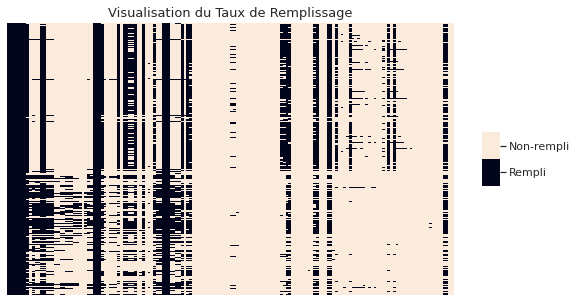

In [77]:
sns.set()
fig, ax = plt.subplots(figsize=(10,5))  # Créer figure

graphe = sns.heatmap(food_raw_data.isnull(),cbar_kws = {'boundaries': np.linspace(-1,2,3), 'shrink': 0.2, 'aspect':3, })
# Note: L'option cbar c'est pour discretiser les couleurs de la barre des couleurs de heatmap.
# d'après : https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot

# Paramètres du texte et légendes
graphe.axes.set_title('Visualisation du Taux de Remplissage', fontsize=13)
graphe.set(xticklabels=[])  # Cacher les labels des deux axes
graphe.set(xlabel=None)
graphe.tick_params(bottom=False)
graphe.set(yticklabels=[])
graphe.set(ylabel=None)
graphe.tick_params(left=False)  # Texte et position de la barre des couleurs
colorbar = graphe.collections[0].colorbar
colorbar.set_ticks([-0.2,1.2])
colorbar.set_ticklabels(['Rempli','Non-rempli'])

# fig.savefig('visual_taux_rempli.png')  # Option pour sauvegarder ce graphe

plt.show()

Nous pouvons voir qu'il y a un nombre important de colonnes qui ne sont pas renseignées pour un grand pourcentage d'articles (de lignes).

Pour faire une première filtration des données, nous allons choisir les colonnes avec un pourcentage important de lignes remplies. Pour cela nous traçons des diagrammes à barres aves les taux de remplissage. Cela permet d'avoir une idée plus visuelle et choisir un pourcentage.

## 4. Premier filtrage: taux de remplisage <a class="anchor" id="premier-filtrage"></a>

### Taux de remplissage par colonnes <a class="anchor" id="taux-colonnes"></a>

On crée un dataframe avec les taux de remplissage

In [3]:
# Serie des valeurs null par colonne
compte_remplissage = food_raw_data.isnull().sum()
variables_total = compte_remplissage.index #les indexes de cette série sont les variables du dataset.

# Création du dataframe avec les taux de remplissage
compte_remplissage_df = pd.DataFrame(variables_total, columns=['variable'])
compte_remplissage_df['nb_rempli'] = food_raw_data.shape[0] - compte_remplissage.values
compte_remplissage_df['pourcentage_rempli'] = round((compte_remplissage_df['nb_rempli']/food_raw_data.shape[0])*100,2)

# Organiser par ordre décroissant du taux
compte_remplissage_df.sort_values(by='nb_rempli', ascending = False, inplace= True, ignore_index = True)

In [4]:
compte_remplissage_df.head()

,variable,nb_rempli,pourcentage_rempli
0,last_modified_t,320772,100.0
1,last_modified_datetime,320772,100.0
2,creator,320770,100.0
3,created_t,320769,100.0
4,created_datetime,320763,100.0


#### Graphe avec variables ordonnées 

Nous traçons le graphe des pourcentages de remplissage pour visualiser les noms de variables et faire un choix. On décide de tracer celles qui ont un pourcentage supérieur à 15% pour avoir une idée.

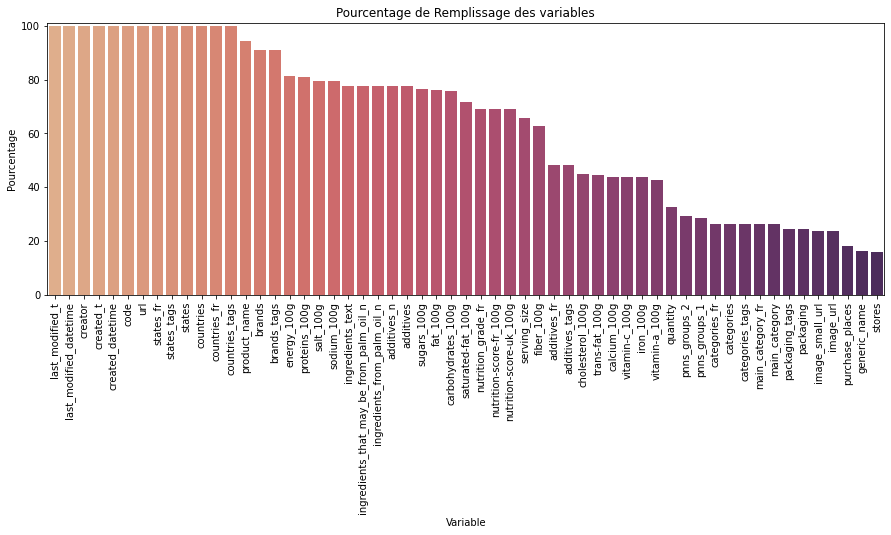

In [5]:
pourcentage = 15  # Choix du pourcentage minimum à tracer

# Choix des variables
variable_min_pourc = compte_remplissage_df.loc[compte_remplissage_df['pourcentage_rempli']>=15]

fig, axes = plt.subplots(figsize=(15,5))
sns.barplot(data = compte_remplissage_df, 
            x = variable_min_pourc['variable'], 
            y = variable_min_pourc['pourcentage_rempli'], 
            palette ="flare")
plt.xticks(rotation=90)
plt.ylim(0,101)
plt.title('Pourcentage de Remplissage des variables')
plt.xlabel('Variable')
plt.ylabel('Pourcentage')

fig.savefig('pourcentage_remplissage.png',bbox_inches='tight')
plt.show()

### Filtrage par taux : choix de variables <a class="anchor" id="filtre-variables"></a>

On choisit de garder les variables:

* **Avec un taux de remplissage supérieur à 40% :** Pour travailler avec une quantité d'information un minimum raisonnable et parce que, selon le graphe précédant, il y en a parmi celles-ci des variables intéréssant pour notre but.

* **Contenant des informations pertinentes :** Celles parmi les variables qui restent qui ont des informations intéressantes pour notre but d'application.

In [6]:
# Premier filtrage : rempli sup à 40%
# liste des noms de variables:
variables = variable_min_pourc.loc[variable_min_pourc['pourcentage_rempli']>= 40]['variable'].tolist()

print(f"Ce qui nous laisse avec {len(variables)} variables d'un total initial de {food_raw_data.shape[1]}.")

Ce qui nous laisse avec 42 variables d'un total initial de 162.


Listons ces variables pour choisir parmi elles celles qui nous intéressent.

In [7]:
print(variables)

['last_modified_t', 'last_modified_datetime', 'creator', 'created_t', 'created_datetime', 'code', 'url', 'states_fr', 'states_tags', 'states', 'countries', 'countries_fr', 'countries_tags', 'product_name', 'brands', 'brands_tags', 'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'ingredients_text', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_from_palm_oil_n', 'additives_n', 'additives', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'nutrition_grade_fr', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'serving_size', 'fiber_100g', 'additives_fr', 'additives_tags', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g', 'iron_100g', 'vitamin-a_100g']


En se basant sur le fait que notre idée d'application concerne l'alimentation par pays, nous faisons le choix de garder :

* Les informations sur les pays, quitte à enlever les redondances après:
    * 'countries'
    * 'countries_fr'
    * 'countries_tags'

* Pour avoir de l'information sur le produit
    * 'product_name'

* Les informations nutritionnelles
    * 'energy_100g' 
    * 'proteins_100g'
    * 'salt_100g'
    * 'sodium_100g'
    * 'sugars_100g'
    * 'fat_100g'
    * 'carbohydrates_100g'
    * 'saturated-fat_100g'
    * 'nutrition_grade_fr'
    * 'fiber_100g'
    * 'cholesterol_100g'
    * 'trans-fat_100g'
    * 'calcium_100g'
    * 'vitamin-c_100g'
    * 'iron_100g'
    * 'vitamin-a_100g'

In [8]:
# Choix final de variables à garder:
variables = ['countries', 'countries_fr', 'countries_tags', 'product_name', 
             'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 
             'ingredients_text', 'sugars_100g', 'fat_100g', 
             'carbohydrates_100g', 'saturated-fat_100g', 'nutrition_grade_fr',
             'fiber_100g', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 
             'vitamin-c_100g', 'iron_100g', 'vitamin-a_100g']

food_data = food_raw_data[variables]  # Dataframe final

print(f'Ce qui nous laisse avec {len(variables)} variables.')

Ce qui nous laisse avec 21 variables.


## 5. Nettoyage <a class="anchor" id="nettoyage"></a>

### Nombre de variables quantitatives et qualitatives 

La commande `food_data.select_dtypes(include=[np.number])` permet de selectionner les colonnes avec des valeurs numériques du dataframe. Dans ce cas, elles sont toutes des variables quantitatives, le reste sont qualitatives.

In [9]:
print('Il y a : \n')
print(f'* {food_data.select_dtypes(include=[np.number]).shape[1]} variables quantitatives et')
print(f'* {food_data.select_dtypes(include=[object]).shape[1]} variables qualitatives.')

Il y a : 

* 15 variables quantitatives et
* 6 variables qualitatives.


On les garde dans des variables puisque cela pourrait être utile

In [10]:
var_quant = food_data.select_dtypes(include=[np.number]).columns.tolist()
var_qualit = food_data.select_dtypes(include=[object]).columns.tolist()

### Variable principale : Pays <a class="anchor" id="pays"></a>

La variable cruciale pour notre objectif est le pays. Dans notre dataset il y a trois variables qui concernent cette information:

* countries : nom anglais des pays où le produit est vendu. **Exemple :** `'Spain,United Kingdom,Scotland'`

* countries_tags : la variable countries normalisée en tags. **Exemple :** `'en:spain,en:united-kingdom,en:scotland'`

* countries_fr : noms français es pays où le produit est vendu. **Exemple :** `'Espagne,Royaume-Uni,en:Scotland'`

Étudions comment complétér les informations sur le pays, laquelle des ces variables garder si l'information est ambigue et comment uniformiser la variable choisie.

* **Nombre de pays**

Actuellement il y a au total **197 pays** reconnus par l'ONU.

In [11]:
print('Il y a: \n')
print(f"* {len(food_data['countries'].unique())} valeurs différentes pour la variable countries")
print(f"* {len(food_data['countries_tags'].unique())} valeurs différentes pour la variable countries_tags")
print(f"* {len(food_data['countries_fr'].unique())} valeurs différentes pour la variable countries_fr")

Il y a: 

* 1435 valeurs différentes pour la variable countries
* 726 valeurs différentes pour la variable countries_tags
* 723 valeurs différentes pour la variable countries_fr


De ces données, et en regardant plusieurs lignes pour la variable countries_tags, on décide :

1. Ne garder que la variable countries_tags, vu l'uniformité de son écriture.

2. Enlever les lignes pour lesquelles countries_tags es manquant. Puisque cette info ne peut pas être déduite des autres colonnes de façon raisonnable.

3. **726** (le nombre `len(food_data[countries_tags].unique())`) est supérieur au nombre total de pays du monde (197) parce qu'il y a des produits qui sont vendus en plusieurs pays. Pour s'assurer que le nom du pays est vraiment uniforme (qu'il n'y a pas de doublons du type `en:united-states` et `en:United States`, par exemple), nous allons compter les apparitions de chaque pays.

On s'assure d'abord que les valeurs manquantes de countries_tags ne puissent pas être complétées avec une des autres variables (countries ou countries_fr).

In [12]:
food_data.loc[(food_data['countries_tags'].isnull() == True) & ((food_data['countries'].isnull() == False) |(food_data['countries_fr'].isnull() == False))]

,countries,countries_fr,countries_tags,product_name,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_text,sugars_100g,...,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g


En effet, on ne peut pas compléter les valeurs manquantes de countries_tags avec les valeurs de countries ou countries_fr. Puisque toutes les lignes où countries_tags n'est pas renseignée, les autres deux variables ne sont pas renseignées non plus.

In [13]:
# 1. Enlever les variables countries et countries_fr
nouv_variables = [var for var in food_data.columns.tolist() if var not in ['countries','countries_fr'] ]
food_data = food_data[nouv_variables]

# 2. Enlever les lignes sans countries_tags 
food_data.dropna(subset='countries_tags', inplace = True)
food_data.reset_index(inplace = True, drop=True)

* **Uniformisation de countries et correction d'erreurs**

In [14]:
# 3. On crée un dataframe pour obtenir un ensemble de tous les pays
# qui apparaissent et pour corriger les erreurs.
countries_df = food_data['countries_tags'].str.split(',', expand=True)
countries_set = set()

countries_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,en:france,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,en:united-states,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,en:united-states,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,en:united-states,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,en:united-states,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [15]:
# Former l'ensemble de tous les pays en regardant toutes
# les différents apparitions dans les colonnes de ce dataframe

for column in countries_df.columns:
    unique_countries_col = set(countries_df[column].unique())
    countries_set = countries_set.union(unique_countries_col)
    
print(f'Il y a {len(countries_set)} pays différents qui apparaissent.')

Il y a 286 pays différents qui apparaissent.


C'est supérieur au nombre total des pays (197), nous allons donc voir cette liste de 286 et faire un dictionnaire à la main pour corriger ces erreurs et doublons. Notre but c'est de garder pour chaque pays une seule chaine de caractères dans le format suivant:

`en:{nom du pays en anglais}`

**Exemple :** pour les états unis `en:united-states`

Puisque la plupart sont déjà comme ça.

In [16]:
# Print pour aider à construire le dictionnaire de correction

countries_list = list(countries_set)

for country in countries_list:
    print(f"'{country}'")

'en:日本'
'es:spanyolorszag'
'en:azerbaijan'
'other-日本'
'en:dominican-republic'
'fr:nagy-britannia'
'en:united-states'
'en:togo'
'en:slovenia'
'en:latvia'
'en:croatia'
'en:mauritius'
'en:zwitserland'
'en:argentina'
'en:monaco'
'en:المملكة-المتحدة'
'en:kina'
'en:mongolia'
'en:pays-bas'
'es:franciaorszag'
'fr:italien'
'en:romania'
'en:finland'
'en:scotland'
'en:سلطنة-عمان'
'en:martinique'
'en:guyana'
'en:etats-unis'
'en:norway'
'en:tunisie'
'en:georgia'
'en:montenegro'
'en:jersey'
'en:andorra'
'fr:sverige'
'es:nemetorszag'
'en:hungary'
'en:mali'
'en:szczecin'
'en:singapore'
'en:united-states-of-america'
'en:kazakhstan'
'en:new-caledonia'
'en:brazil'
'en:niger'
'Emballage complété'
'es:danemark'
'en:spain'
'en:香港'
'en:portugal'
'en:france'
'en:australie'
'fr:marseille-6'
'other-العراق'
'en:estonia'
'en:paraguay'
'en:libya'
'en:somalia'
'de:weltweit'
'en:ghana'
'other-japon'
'en:भारत'
'en:philippines'
'en:sweden'
'en:iceland'
'en:frankrijk'
'fr:republik-china'
'en:Packaging-code-completed'
'

In [17]:
dict_corrections = {'fr:nagy-britannia' : 'en:united-kingdom',
                    'es:nemetorszag' : 'en:germany',
                    'en:gulf-countries' : None,
                    'Photos envoyées' : None,
                    'Catégories complétées' : None,
                    'en:الإمارات-العربية-المتحدة':'en:united-arab-emirates' ,
                    'en:البحرين':'en:bahrain',
                    'en:السعودية':'en:saudi-arabia',
                    'en:भारत':'en:india',
                    'en:日本':'en:japan',
                    'en:香港':'en:hong-kong',
                    'fr:quebec': 'en:canada',
                    'en:quebec':'en:canada',
                    'other-japon':'en:japan',
                    'other-turquie':'en:turkey',
                    'other-العراق':'en:iraq',
                    'other-日本' : 'en:japan',
                    'en:azərbaycan':'en:azerbaijan',
                    'en:deutschland':'en:germany',
                    'en:turkiye': 'en:turkey',
                    'en:republique-de-chine' : 'en:taiwan',   
                    'fr:sverige' : 'en:sweden',
                    'en:finand' : 'en:finland',  
                    'fr:nederland' : 'en:netherlands', 
                    'en:tunisie':'en:tunisia',
                    'en:zwitserland' : 'en:switzerland',
                    'fr:republik-china' : 'en:taiwan',
                    'fr:spanien': 'en:spain',
                    'es:spanyolorszag' : 'en:spain',
                    'xx:danemark': 'en:denmark',
                    'Date limite complétée': None,
                    'en:العراق': 'en:iraq',
                    'A compléter' : None,
                    'en:frankrike' : 'en:france',
                    'en:Packaging-code-completed' : None,   
                    'en:australie':'en:australia',
                    'en:soviet-union': 'en:russia',
                    'en:sint-maarten': 'en:saint-martin',
                    'en:united-states-of-america' :'en:united-states',
                    'fr:niederlande' : 'en:netherlands',
                    'en:italiaans' : 'en:italy',   
                    'fr:scotland' : 'en:scotland',
                    'en:المملكة-المتحدة': 'en:united-kingdom',
                    'fr:deutschland': 'en:germany',
                    'en:cote-d-ivoire' : 'en:ivory-coast',
                    'Quantité complétée' : None,    
                    'fr:puyricard' : 'en:france',
                    'en:казахстан' : 'en:kazakhstan',
                    'Emballage complété' : None,
                    'de:royaume-uni' : 'en:united-kingdom',
                    'en:sverige' : 'en:sweden',
                    'fr:svajc' : 'en:switzerland',
                    'other-العراق' : 'en:iraq',
                    'es:spanien' : 'en:spain',
                    'en:etats-unis' : 'en:united-states',
                    'en:frankreich' : 'en:france',
                    'nl:pays-bas' : 'en:netherlands',
                    'en:allemagne' : 'en:germany',
                    'en:island' : None,
                    'es:portugalia' : 'en:portugal',
                    'fr:bouches-du-rhone' : 'en:france',
                    'en:all-over-the-world' : None,
                    'en:سلطنة-عمان' : 'en:oman',
                    'en:spanien' : 'en:spain',
                    'fr:tschechien' : 'en:czech-republic',
                    'other-turquie' : 'en:turkey',
                    'en:global-market': None,
                    'en:belgique' : 'en:belgium',
                    'en:ประเทศออสเตรเลีย' : 'en:australia',
                    'de:allemagne':'en:germany',
                    'en:สหราชอาณาจักร': 'en:united-kingdom',
                    'fr:australien' : 'en:australia',
                    'en:szczecin' : 'en:poland',
                    'en:kina' : 'en:china',
                    'de:espagne' : 'en:spain',
                    'en:frankrijk' : 'en:france',
                    'es:nagy-britannia' : 'en:united-kingdom',
                    'fr:aix-en-provence' : 'en:france',
                    'Ingrédients à compléter' : None,
                    'fr:paca' : 'en:france',
                    'Caractéristiques complétées' : None,
                    'Nom du produit complete' : None,
                    'en:czech': 'en:czech-republic',
                    'en:quebec' : 'en:canada',
                    'en:تونس':'en:tuinisia',
                    'Informations nutritionnelles complétées':None,
                    'en:worldwide':None,
                    'fr:belgien' : 'en:belgium',
                    'A vérifier' : None,
                    'en:an' : None,
                    'en:spanje': 'en:spain',
                    'es:deutschland': 'en:germany',
                    'en:republique-de-chine' : 'en:taiwan',
                    'en:日本': 'en:japan',
                    'fr:belgie': 'en:belgium',
                    'es:espagne':'en:spain',
                    'en:ประเทศไทย':'en:thailand',
                    'france' : 'en:france',
                    'en:belgien':'en:belgium',
                    'en:niederlande':'en:netherlands',
                    'fr:magyarorszag' : 'en:hungary',
                    'fr:frankrijk' : 'en:france',
                    'en:european-union' : None,
                    'en:nederland' :'en:netherlands',
                    'en:السعودية': 'en:saudi-arabia',
                    'en:pays-bas':'en:netherlands',
                    'en:royaume-uni': 'en:united-kingdom',
                    'en:denemarken' : 'en:denmark',
                    'fr:italien' : 'en:italy',
                    'Marques complétées': None,
                    'en:turkiye' : 'en:turkey',
                    'de:weltweit' : None,
                    'fr:77-provins' : None,
                    'es:danemark' : 'en:denmark',
                    'fr:schweiz' : 'en:switzerland',
                    'Photos validées' : None,
                    'Ingrédients complétés' : None,
                    'en:other-日本' : 'en:japan',
                    'en:भारत' : 'en:india',
                    'es:magyarorszag': 'en:hungary',
                    'fr:cora' : 'en:france',
                    'Photos à valider' : None,
                    'en:zweden' : 'en:sweden',
                    'fr:frankreich': 'en:france',
                    'fr:vereinigtes-konigreich' : 'en:united-kingdom',
                    'en:belgie': 'en:belgium',
                    'en:noorwegen':'en:norway',
                    'fr:bourgogne-aube-nogent-sur-seine' : 'en:france',
                    'Complet' : None,
                    'en:world':None,
                    'Date limite à compléter':None,
                    'en:angleterre':'en:united-kingdom',
                    'fr:quebec':'en:canada',
                    'en:croacia' : 'en:croatia',
                    'fr:marseille-6' : 'en:france',
                    'other-japon': 'en:japan',
                    'ar:tunisie' : 'en:tuinisia',
                    'en:duitsland' : 'en:germany',
                    'es:franciaorszag' : 'en:france'
}

In [18]:
# Correction de ces erreurs : 
countries_df.replace(dict_corrections,inplace=True)

# Enlever le prefix 'en:'
for column in countries_df.columns:
    countries_df[column] = countries_df[column].str[3:]

Avec les noms de pays corrigés, on refait la liste des valeurs différents qui apparaissent:

In [19]:
new_countries_set = set()

for column in countries_df.columns:
    unique_countries_col = set(countries_df[column].unique())
    new_countries_set = new_countries_set.union(unique_countries_col)
    
new_countries_set = new_countries_set - {None}
    
print(f'Il y a {len(new_countries_set)} pays différents qui apparaissent.')

Il y a 158 pays différents qui apparaissent.


C'est très raissonnable maintenant puisque 158 < 197 le nombre total de pays.

1. Nous enregistrons maintenant cette liste de pays puisqu'elle sera utile pour l'analyse après, et

2. nous corrigeons la colonnes countries_tags en joignant le dataframe de tous les pays (nous l'avons *splité*, corrigé, et maintenant nous le *des-splitons*).


In [20]:
# 1. Enregistrer liste de pays pour utiliser après
# en utilisant le module "pickle" de python

countries_list = list(new_countries_set)
countries_list.sort()

with open('countries_list.data','wb') as fichier:
    pickle.dump(countries_list,fichier)
    
# Note: Pour le lire, utiliser :
#
# with open('countries_list.data','rb') as fichier:
#     countries_list = pickle.load(fichier)

In [21]:
# 2. Remplacer la colonne countries_tags par celle où
# nous avons corrigé et uniformisé les noms: join sur les
# colonnes du dataframe des pays

food_data['countries_tags'] = countries_df.agg(lambda tags: ','.join(filter(None,tags)), axis=1)

# Les lignes où il y avait des erreurs ou des pays
# sans determiner, resultent comme le string vide en tant
# que countries_tags. Nous enlevons ces lignes.

print(f"Il y a {food_data.loc[food_data['countries_tags'] == ''].shape[0]} lignes sans pays, qui seront supprimmées.")

food_data = food_data.loc[food_data['countries_tags'] != '']

Il y a 74 lignes sans pays, qui seront supprimmées.


### Valeurs manquantes 

#### A. Variables quantitatives <a class="anchor" id="quantitatives"></a>

Pour les valeurs manquantes des variable quantitatives qui sont des valeurs nutritionnelles, par exemple, proteines_100g, nous allons remplacer les valeurs non-renseignées par 0. En effet ; la plupart de ces variables sont des macronutriments (proteines, lipides, glucides) ou micronutriments (vitamines, minéraux) donc nous allons supposer que si ces nutriments n'ont pas été renseignées, alors le produit ne contient pas le nutriment: il contient 0 gr.

Il faut donc d'abord séléctionner ces variables, et ensuite faire le remplacement.

In [22]:
# Rappel les variables quantitatives
var_quant

['energy_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'sugars_100g',
 'fat_100g',
 'carbohydrates_100g',
 'saturated-fat_100g',
 'fiber_100g',
 'cholesterol_100g',
 'trans-fat_100g',
 'calcium_100g',
 'vitamin-c_100g',
 'iron_100g',
 'vitamin-a_100g']

In [23]:
food_data[var_quant].isna().sum()

energy_100g            59392
proteins_100g          60593
salt_100g              64988
sodium_100g            65035
sugars_100g            75524
fat_100g               76610
carbohydrates_100g     76914
saturated-fat_100g     90944
fiber_100g            119575
cholesterol_100g      176331
trans-fat_100g        177121
calcium_100g          179373
vitamin-c_100g        179551
iron_100g             179958
vitamin-a_100g        182866
dtype: int64

In [24]:
# Remplacer les valeurs NaN par 0.
food_data[var_quant] = food_data[var_quant].fillna(value=0)

Il reste à traiter trois variables:

* product_name

* ingredients_text

* nutrition_grade_fr

La variable **nutrition_grade_fr**, sera traitée en dernier. 

La variable product_name a environs 18 000 valeurs manquantes et la variable ingredients_text a environs 72 000 valeurs manquantes. On considère que ces variables sont importantes, peut-être pas pour l'analyse mais pour l'idée d'application puisqu'il s'agit d'avoir des informations sur les produits pour le marketing par exemple, donc il faut avoir une idée de ce que c'est (product_name) ou bien des ingrédients (ingredients_text). Ou s'il n'y a pas une de ces valeurs on peut se guider par l'autre pour savoir quel type de produit c'est. 

Suivant ce raisonnment, on elimine les lignes qui n'ont ni product_name ni ingredients_text, et pour le reste on remplace par un string vide les valeurs manquantes.

In [25]:
indices_a_enlev = food_data.loc[(food_data['product_name'].isna() == True) & (food_data['ingredients_text'].isna() == True)].index

print(f'Cela fait {len(indices_a_enlev)} lignes à enlever, sur environs 320 000')

Cela fait 15862 lignes à enlever, sur environs 320 000


In [26]:
var_qualit

['countries',
 'countries_fr',
 'countries_tags',
 'product_name',
 'ingredients_text',
 'nutrition_grade_fr']

In [27]:
# Enlever lignes sans product_name et sans ingredients_text
food_data.drop(index = indices_a_enlev, inplace=True)
food_data.reset_index(inplace=True, drop=True)

# Remplacer valeurs manquantes de product_name et sans ingredients_text
# par  le string vide''

food_data[['product_name','ingredients_text']] = food_data[['product_name','ingredients_text']].replace(np.nan,'') 

* **Outliers et erreurs**

Toutes les variables de la liste var_quant (les variables quantitatives), sauf energy_100g, doivent prendre des valeurs entre 0 et 100. Sinon c'est un erreur. En effet ; c'est la quantité en grammes pour une quantité 100g du produit.

Pour la variable energy_100g, la valeur energetique des aliments par 100g est mesuré en kilojoules ou  kilocalories, donc en général cette valeur sera largement supérieur à 100. Donc on la considère pas pour étudier cette erreur.

Nous allons donc d'abord enlever les erreurs : les lignes où les valeurs (pour ces variables) sont inférieures à 0 ou supérieures à 100.

In [28]:
# Choisir les bonnes variables: nutriment par 100g
nutriments_corrections = [var for var in var_quant if var != 'energy_100g']

# Voir combien d'erreurs par variable avant d'effacer ces lignes.
for var in nutriments_corrections:
    index_list = food_data.loc[(food_data[var] < 0) | (food_data[var] > 100)].index.tolist()
    print(len(index_list), '\t', var)

4 	 proteins_100g
157 	 salt_100g
34 	 sodium_100g
18 	 sugars_100g
4 	 fat_100g
18 	 carbohydrates_100g
3 	 saturated-fat_100g
5 	 fiber_100g
0 	 cholesterol_100g
9 	 trans-fat_100g
10 	 calcium_100g
4 	 vitamin-c_100g
1 	 iron_100g
1 	 vitamin-a_100g


In [29]:
# Liste d'indices des lignes avec les erreurs, à enlever 
index_list_remove=[]

for var in nutriments_corrections:
    index_list_remove += food_data.loc[(food_data[var] < 0) | (food_data[var] > 100)].index.tolist()
    
# Enlever ces lignes du dataframe
print(f'Suppression de {len(index_list_remove)} lignes.')
food_data.drop(index=index_list_remove, inplace = True)
food_data.reset_index(inplace = True, drop=True )

Suppression de 268 lignes.


### Visualisation des variables nutriments : visualiser outliers

Nous traçons des boîtes à moustaches (boxplot) et les valeurs des variables nutriments pour identifier des outliers

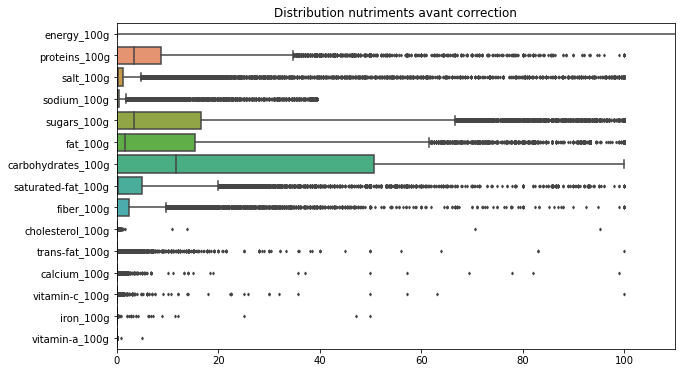

In [30]:
warnings.simplefilter(action='ignore', category=FutureWarning)

fig = plt.figure(figsize=(10, 6))
sns.boxplot(data = food_data[var_quant], orient='h', whis=3, fliersize=2)
sns.set(rc={'figure.figsize':(10,6)})
plt.xlim(0,110)
plt.title('Distribution nutriments avant correction')
plt.savefig('distribut_nutri_avt_corr.png',bbox_inches='tight')
plt.show()

**Distribution nutriments variable par variable:**

Voyons chacune de ces variables avec plus de détail.

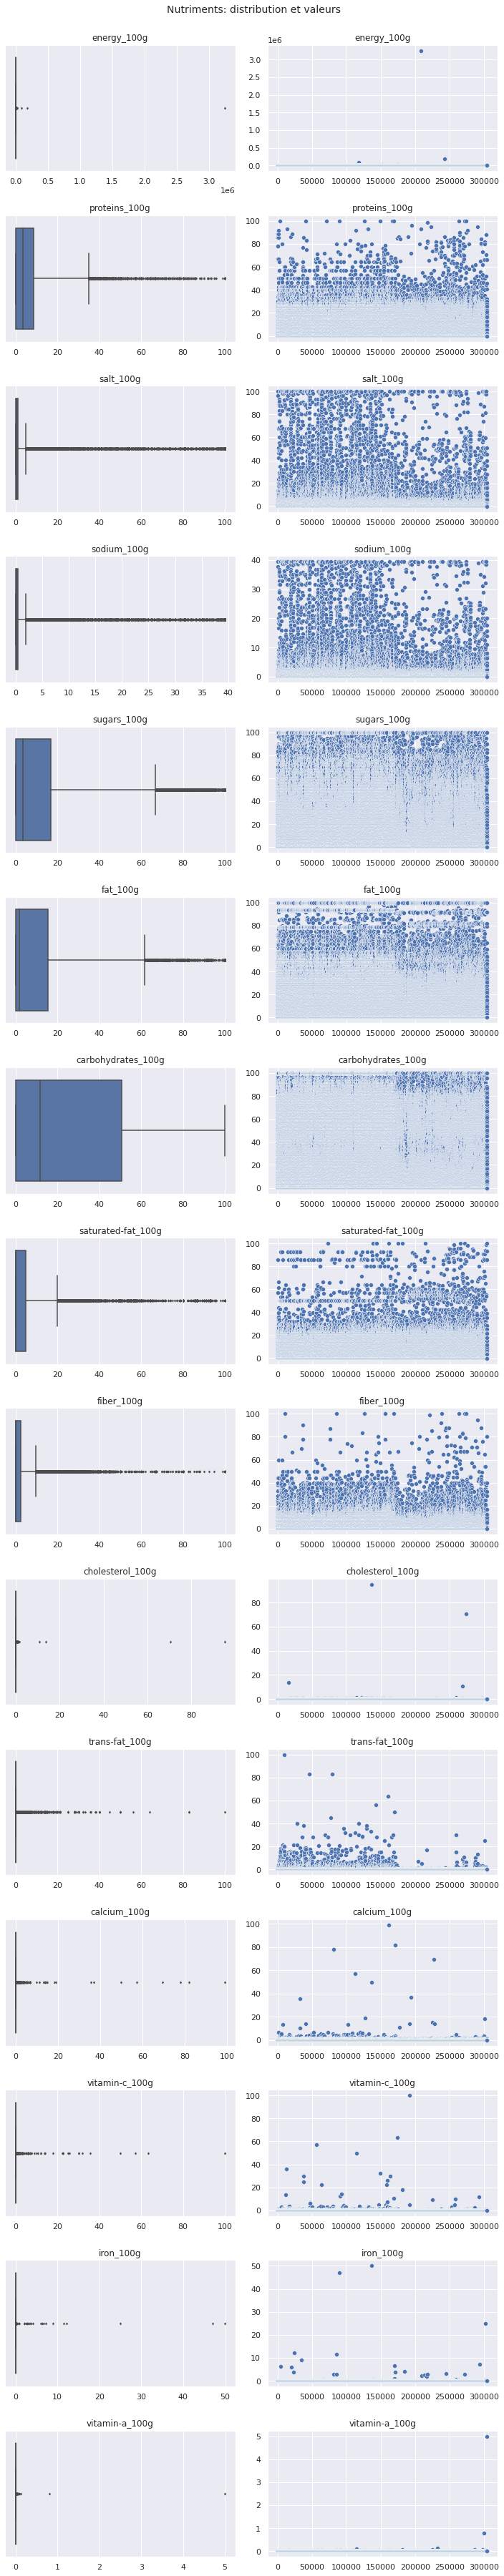

In [31]:
n_nutri = len(var_quant)
total_lignes_suppr = 0  # Variable pour compter suppressions 


fig, axs = plt.subplots(n_nutri, 2, figsize=(10,50))
fig.suptitle('Nutriments: distribution et valeurs', fontsize=14, y=1)

for var in var_quant:
    i = var_quant.index(var)
    
    sns.boxplot(x=food_data[var], whis=3, fliersize=2, ax=axs[i,0])
    axs[i, 0].set_title(var)
    axs[i,0].set(xlabel=None)
    sns.scatterplot(data=food_data,x=food_data.index,y=food_data[var], ax = axs[i, 1])
    axs[i, 1].set_title(var)
    axs[i,1].set(ylabel=None)

plt.tight_layout()
fig.savefig('nutrim_distr_et_val.png',bbox_inches='tight')

Nous avons bien des valeurs qui sont atypiques, mais ce ne semble pas raisonnable de les enlever. Pour certaines variables il y énormément d'ouliers. Par exemple, les produits avec 100 grammes de sel dans la variables quantité de sel par 100g c'est du sel. Ou la variable avec 100 gramme de vitamine C, c'est de la vitamine C. On décide de les garder.

#### Étude de valeurs atypiques et aberrantes au cas par cas

Regardons en détail les lignes de ces valeurs qui sont des outliers pour décider lesquelles éliminer.

In [32]:
def indexes_of_outliers(dataframe,variable):
    """
    Indice des outliers pour la variable variable. Où
    les outliers sont ici définis comme les valeurs supérieurs
    au troisième quartile plus trois fois l'écart interquartiles,
    ou inférieur au premier quartile mois trois fois l'écart
    interquartiles.
    
    Arguments: 
        dataframe: pandas.core.frame.DataFrame
        variable: label de colonne, string.
    Résultat:
        pandas.core.indexes.numeric.Int64Index
    """
    Q1 = dataframe[variable].quantile(q=0.25)
    Q3 = dataframe[variable].quantile(q=0.75)
    ecart = Q3 - Q1
    
    inf = Q1 - 3 * ecart
    sup = Q3 + 3 * ecart
    
    indexes = dataframe.loc[(dataframe[variable]<inf) | (dataframe[variable]>sup)].index
    
    return indexes

Combien d'outliers par variable? (outliers selon la méthode interquartiles avec 3 fois l'écart interquartiles)

In [33]:
print('Nom variable', '\t', "Nombre d'outliers")
print('----------------------------------------')
for var in var_quant:
    print(f'{var:<20}', len(indexes_of_outliers(food_data,var)))


Nom variable 	 Nombre d'outliers
----------------------------------------
energy_100g          44
proteins_100g        2328
salt_100g            9965
sodium_100g          9965
sugars_100g          9448
fat_100g             5599
carbohydrates_100g   0
saturated-fat_100g   9938
fiber_100g           12714
cholesterol_100g     54604
trans-fat_100g       2987
calcium_100g         34615
vitamin-c_100g       50284
iron_100g            20160
vitamin-a_100g       58863


Cette méthode enleverait énormement d'individus. Ce critère est très stricte pour notre cadre, puisqu'il s'agît de produits alimentaires où c'est assez normal d'avoir des valeurs atypiques, qui ne sont pas forcément des erreurs.

On va prendre un échantillon pour chacune de ces variables pour étudier s'il y a vraiment beaucoup d'erreurs ou ce sont juste des valeurs atypiques.

* **energy_100g:**

Il y a un grand problème avec cette variable, nous décidons de la supprimer.

Voici l'explication du problème: On a supposé qu'elle renseigne la quantité d'énergie en kC (ou kJ. 1 kC = 4kJ), car sur les renseignements il n'y a plus d'information. Déjà, on ne sait pas si c'est de kC ou des kJ. D'un autre côté si on suppose que c'est des kC, en enlèvent les valeurs aberrantes (>5000), nous avons:

* la moyenne ~ 957
* la mediane ~ 837
* la deviation standard ~ 837

Il s'avère que la moyenne de quantité d'energie par 100g pour les aliments qui sont considérés comme "junk food" est **seulement de 550 kC** (voir [source](https://www.gbhealthwatch.com/Nutrient-Calorie-TopFoods.php)). Et que les aliments avec le plus de calories c'est les huiles, les gras animal qui ont en moyenne **900 kC** par 100g.

Si cette variable était bien renseignée, ça nous laisserait penser que la plupart de produits dans la base sont des huiles ou gras animal pur. Mais vu qu'on a une deviation standard très haute, on conclut que les informations renseignées pour beaucoup de produits ce n'est pas la quantité d'energie pour 100g mais pour le produit tout entier.

Si on décide de choisir donc les valeurs raisonnables (energie en dessous de 900), nous avons maintenant une moyenne raisonnable de quantité d'energie par 100g (~260gr), mais ça nous laisse la moitié de notre dataset. Il faudrait enlever environs 150 000 lignes !

Pour ces raisons on décide d'enlever la variable energy_100g.

Voici les mesures centrales et de dispersion:

In [34]:
food_data['energy_100g'].describe()

count    3.043390e+05
mean     9.701944e+02
std      5.963787e+03
min      0.000000e+00
25%      1.760000e+02
50%      8.370000e+02
75%      1.594000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

In [35]:
food_data.loc[food_data['energy_100g']<900]['energy_100g'].describe()

count    157227.000000
mean        256.396940
std         269.325755
min           0.000000
25%           0.000000
50%         188.000000
75%         444.000000
max         899.000000
Name: energy_100g, dtype: float64

Suite à notre décision, on enleve la variable energy_100g:

In [36]:
food_data = food_data.drop(columns = ['energy_100g'])

* **proteins_100g**

Nous regardons en détail un échantillon aléatoire

In [37]:
food_data.iloc[indexes_of_outliers(food_data,'proteins_100g')].sample(20)

,countries_tags,product_name,proteins_100g,salt_100g,sodium_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
126035,united-states,Smoked Boar,46.43,4.08178,1.607000,"Boar, dry honey (refinery syrup, honey), flavo...",14.29,7.14,17.86,1.79,d,0.0,0.125,0.0,0.000,0.0000,0.00257,0.000107
164664,united-states,Dry Roasted Seaweed,40.00,2.54000,1.000000,"Seaweed, corn oil, hot pepper oil, sesame oil,...",0.00,40.00,20.00,0.00,d,20.0,0.000,0.0,0.000,0.0720,0.00720,0.002400
156305,united-states,"Free-Range Turkey Jerky, Spiracha Honey",40.00,2.27076,0.894000,"Free range turkey, tamari sauce (water, organi...",11.76,2.35,14.12,0.00,d,0.0,0.082,0.0,0.000,0.0028,0.00169,0.000071
152005,united-states,"La Quercia, Salami Americano Garlic And Black ...",35.71,4.53644,1.786000,"Pork, water, salt, dextrose, spices, natural f...",0.00,21.43,0.00,7.14,e,0.0,0.125,0.0,0.071,0.0000,0.00129,0.000000
19782,united-states,Protein Ultra Thin Pizza Crust,38.10,1.57226,0.619000,"Water, enriched flour (wheat flour, enzyme, ni...",0.00,2.38,21.43,0.00,b,2.4,0.012,0.0,0.048,0.0000,0.00643,0.000000
63991,united-states,Beef Jerky,39.29,5.44322,2.143000,"Beef, water, brown sugar, salt, contains 2% or...",21.43,3.57,21.43,0.00,d,0.0,0.054,0.0,0.000,0.0000,0.00386,0.000000
297648,france,Chicken,53.00,4.00000,1.574803,"Viande de poulet crue 60 g, sel, sucre, _hydro...",0.10,4.00,1.00,1.60,d,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
295436,france,ISO Fraise,80.50,0.02000,0.007874,,7.46,0.00,0.00,0.50,b,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
57978,united-states,"Thick Sliced Bacon, Cherrywood Smoked",36.36,7.62000,3.000000,"Pork, water, salt, cane sugar, brown sugar, so...",0.00,45.45,0.00,18.18,NaN,0.0,0.045,0.0,0.000,0.0000,0.00000,0.000000
149270,united-states,Protein Pancake Mix,38.57,2.30886,0.909000,"Whey protein isolate, gluten free oat flour, b...",11.43,10.00,34.29,1.43,d,5.7,0.014,0.0,0.357,0.0000,0.00386,0.000000


La plupart de ces produits sont de la viande, de barres de proteines, etc. Si on regarde ceux avec un taux vraiment très haut de proteines pour corriger des erreurs :

In [38]:
food_data.loc[food_data['proteins_100g']>70].sample(20)

,countries_tags,product_name,proteins_100g,salt_100g,sodium_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
269770,france,100% Real Whey Protein Stevia Banana,80.00,0.00000,0.000000,,3.30,5.900,4.90,2.20,NaN,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
302666,france,"Boite Metallique Ronde, Bonbon, Rose, 20 cm Et...",88.00,0.00000,0.000000,,7.00,0.000,0.00,99.00,d,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
269768,france,100% Real Whey Protein Stevia Fraise,79.00,0.33000,0.129921,"Concentré de protéine de _lactosérum_ (97%), A...",3.20,5.900,5.70,1.70,b,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
269008,ireland,Isopure,85.70,2.10000,0.826772,,1.10,2.700,3.10,1.10,c,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
256005,france,Purya Vegan Protein Rice,83.00,0.50000,0.196850,,0.50,0.000,0.00,3.50,a,3.9,0.000,0.0,0.000,0.0000,0.00000,0.000000
268,germany,Mehrkomponeneten Protein 90 C6 Banane,85.50,0.00000,0.000000,"Proteinmischung (_Sojaprotein_, _Weizenprotein...",0.00,1.000,2.50,0.00,NaN,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
144519,united-states,"Jarrow Formulas, Brown Rice Protein Concentrat...",70.59,0.14986,0.059000,"Non-gmo brown rice protein, cocoa powder, natu...",0.00,0.000,11.76,0.00,a,5.9,0.000,0.0,0.294,0.0071,0.01588,0.000176
262,germany,Mehrkomponeneten Protein 90 C6 Schoko,85.50,0.00000,0.000000,"Proteinmischung (_Sojaprotein_, _Weizenprotein...",0.00,1.000,2.50,0.00,NaN,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000
67149,united-states,Coco Candy,71.93,0.15494,0.061000,"Coconut, sugar.",40.35,42.110,31.58,40.35,e,5.3,0.105,0.0,0.000,0.0021,0.00189,0.000000
295436,france,ISO Fraise,80.50,0.02000,0.007874,,7.46,0.000,0.00,0.50,b,0.0,0.000,0.0,0.000,0.0000,0.00000,0.000000


Dans ce sous-échantillon on peut voir que la plupart de produits si riches en proteines c'est des poudre de protéines pour faire des boissons. Ce sont donc des valeurs normales, ce n'est pas des erreurs. Par contre on retrouve quelques erreurs, comme des Gressins, des lingettes nettoyantes ou du vinaigre. Le nombre total de ces produits c'est 148.

**Correction des erreurs:** Nous allons garder donc parmi ces individus là, seulement ceux qui contienent le string 'prot' dans le nom ou les ingrédients (ça permet d'inclure ceux qui sont en français et en anglais): ce sont 73 sur 148, donc la moitié.

In [39]:
# série de booleans: True si 'prot' est contenu dans product_name
series_name = food_data.loc[food_data['proteins_100g']>70]['product_name'].str.contains('prot', case=False, regex=True)
indices_false_name = set(series_name.loc[series_name == False].index.tolist())

# série de booleans: True si 'prot' est contenu dans ingredients_text
series_ingr = food_data.loc[food_data['proteins_100g']>70]['ingredients_text'].str.contains('prot', case=False, regex=True)
indices_false_ingr = set(series_ingr.loc[series_ingr == False].index.tolist())

# intersection de ces indices: ne contiennent 'prot' ni dans les
# ingredients ni dans le nom
indices_supprimer = list(indices_false_name.intersection(indices_false_ingr))

# Suppression lignes
food_data.drop(index = indices_supprimer, inplace= True)
print(f'Nombres de lignes supprimées: {len(indices_supprimer)}')
total_lignes_suppr += len(indices_supprimer)

Nombres de lignes supprimées: 75


* **salt_100g**

Nous regardons les individus avec un taux de sel très haut pour voir ss'il y a des erreurs. Quand on prend un échantillon aléatoire de 20 individus, on voit par le nom du produit que ce sont tous du sel, du sel d'ail, des assaisonnements. C'est donc normal pour ces produits d'avoir autant de sel. Nous gardons donc tous les individus.

In [40]:
food_data.loc[food_data['salt_100g']>80].sample(20)

,countries_tags,product_name,proteins_100g,salt_100g,sodium_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
38364,united-states,"Salt, Garlic",0.0,88.90000,35.000000,"Salt, garlic, calcium silicate (added to make ...",0.0,0.0,0.0,0.0,c,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
45228,united-states,"Adobo, All Purpose Seasoning With Cumin",0.0,86.36000,34.000000,"Salt, cumin, tricalcium phosphate (prevents ca...",0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
49545,united-states,Iodized Salt,0.0,99.90582,39.333000,"Salt, sodium silicoaluminate, dextrose, potass...",0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
63273,united-states,"Culinary, Mediterranean Style Sea Salt, Fine G...",0.0,99.90582,39.333000,Fine grind mediterranean style sea salt,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
89512,united-states,Gourmet Natural Seanoning,0.0,91.44000,36.000000,"Salt crystals (earth and sea), vegetable mixtu...",0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
273510,sweden,Finkornigt hushållssalt med jod,0.0,99.90000,39.330709,"Salt (NaCl) min 99.9%, Jod (KI) 5 mg/100g, Klu...",0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
106671,united-states,Meat Tenderizer,0.0,86.36000,34.000000,"Salt, sugar, spices (including chili pepper), ...",0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9834,united-states,Coarse Sea Salt,0.0,99.90582,39.333000,Sea salt.,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
33221,united-states,Seasoned Salt,0.0,90.05570,35.455000,"Salt, spices (including paprika & turmeric for...",0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
28544,united-states,Garlic Salt,0.0,80.43418,31.667000,"Salt, garlic and tricalcium phosphate (as anti...",0.0,0.0,0.0,0.0,c,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


* **sodium_100g**

En chercheant des informations* sur le sodium on conclut que ce n'est pas une information très représentative ici : en effet pour les aliments on retrouve le sodium dans le sel qu'ils contiennent. Et nous avons déjà l'information sur le sel. De plus, il n'y a que 387 mg = 0.387 gr dans chaque gramme de sel. Donc ces quantité ne sont pas dans la bonnes échelle pour les comparer avec les autres nutriments.

On décide de supprimer la variable sodium_100g.

*[source: Understanding food labels](https://www.eatforhealth.gov.au/sites/default/files/content/Eating%20Well/efh_food_label_example_large.pdf)

In [41]:
food_data.drop(columns=['sodium_100g'], inplace= True)

* **sugars_100g**

Les ouliers définis par la méthode interquartiles sont ceux avec une valeurs de sucre supérieur à 67 g. On prends aléatoirement un sous-échantillon pour avoir une idée de s'il y a des erreurs parmi ces individus.

In [42]:
food_data.iloc[indexes_of_outliers(food_data,'sugars_100g')].sample(20)

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
6231,united-states,Dark Chocolate Pistachio Toffee,10.42,0.29210,"Dark chocolate (sugar, chocolate liquor, cocoa...",54.17,31.25,60.42,14.58,e,4.2,0.031,0.00,0.042,0.0000,0.00150,0.000125
9482,united-states,"Star Brites Candy, Peppermint",0.00,0.00000,"Corn syrup, sugar, peppermint oil, titanium di...",73.33,0.00,100.00,0.00,NaN,0.0,0.000,0.00,0.000,0.0000,0.00000,0.000000
55558,united-states,"Drink Mix, Sharkleberry Fin",0.00,0.00000,"Sugar, fructose, citric acid, contains less th...",94.12,0.00,94.12,0.00,NaN,0.0,0.000,0.00,0.000,0.0353,0.00000,0.000000
72882,united-states,Cookie Icing Set,0.00,0.07366,Green cookie icing ingredients: confectioners'...,74.29,2.86,77.14,1.43,d,0.0,0.000,0.00,0.000,0.0000,0.00000,0.000000
101709,united-states,Banana Pepper Rings,0.00,2.81178,"Banana peppers, water, vinegar, salt, malic an...",0.00,0.00,3.57,0.00,NaN,0.0,0.000,0.00,0.000,0.0000,0.00000,0.000000
159545,united-states,"Plus, Organic Pureed Baby Food, Strawberry, Ki...",0.83,0.03048,"Organic pear puree, water, organic beet puree,...",7.50,1.25,11.67,0.00,a,3.3,0.000,0.00,0.125,0.0900,0.00120,0.000025
93951,united-states,Oatmeal Raisins Mini Cookies,7.41,0.75184,"Oats, brown sugar, raisins, enriched wheat flo...",37.04,14.81,62.96,7.41,d,3.7,0.037,0.00,0.074,0.0000,0.00267,0.000111
30934,united-states,Red Fish,0.00,0.06350,"Sugar, corn syrup, modified corn starch, inver...",60.00,0.00,85.00,0.00,d,0.0,0.000,0.00,0.000,0.0000,0.00000,0.000000
72925,united-states,Decorating Kit,0.00,0.00000,"Light bulbs: dextrose, corn syrup, citric acid...",78.57,0.00,85.71,0.00,NaN,0.0,0.000,0.00,0.000,0.0000,0.00000,0.000000
19904,united-states,French Style Green Beans,0.83,0.61468,"Green beans, water, salt.",1.67,0.00,3.33,0.00,b,1.7,0.000,0.00,0.017,0.0030,0.00060,0.000050


Ces produits sont du sucre, du miel ou des bonbons. Donc ce ne sont pas des erreurs. Nous gardons tous les individus.

* **fat_100g**

Le sous-échantillon suivant montre que les produits considérés comme des outliers par la méthode interquartiles sont en réalité du beurre, de l'huile, des sauces ou de noix. C'est normal que le contenu de lipides de ces produits soit assez haut et on ne voit pas d'erreurs donc on garde tous les individus.

In [43]:
food_data.reset_index(drop=True, inplace=True)
food_data.iloc[indexes_of_outliers(food_data,'fat_100g')].sample(20)

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
95512,united-states,Salted Butter,0.00,1.63322,"Pasteurized cream, salt.",0.00,78.57,0.00,50.00,e,0.0,0.214,0.0,0.000,0.0,0.00000,0.000857
290612,france,Condimento a base di Olio Extra Vergine di Oli...,0.00,0.00000,,0.00,92.00,0.00,14.00,d,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000
146478,united-states,"Frankie V's Kitchen, Toasted Sunflower Seed Bu...",7.14,0.00000,"Organic toasted sunflower seeds, organic sunfl...",7.14,71.43,21.43,7.14,d,7.1,0.000,0.0,0.000,0.0,0.00514,0.000000
160744,united-states,Extra Virgin Olive Oil,0.00,0.00000,Extra virgin olive oil,0.00,93.33,0.00,13.33,NaN,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000
58178,united-states,Extra Virgin Olive Oil,0.00,0.00000,100% spanish extra virgin olive oil,0.00,90.00,0.00,13.33,NaN,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000
159411,united-states,Organic Coconut Oil,0.00,0.00000,"Organic, refined, expeller-pressed coconut oil.",0.00,93.33,0.00,86.67,NaN,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000
155841,united-states,Extra Virgin Olive Oil,0.00,0.00000,Olive oil,0.00,93.33,0.00,13.33,NaN,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000
191707,france,Le Beurre Gourmand Noisy,0.70,0.05000,Beurre doux,0.80,82.00,0.80,53.00,e,0.0,0.000,0.0,0.000,0.0,0.00000,0.000800
27197,united-states,"Aj's Purveyors Of Fine Foods, 100% Extra Virgi...",0.00,0.00000,100% extra virgin california olive oil,0.00,100.00,0.00,10.71,NaN,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000
297650,serbia,Majonez delikates,1.10,1.00000,"rafinisano suncokretovo ulje min. 75%, voda, _...",2.10,76.80,2.60,9.80,e,0.0,0.000,0.0,0.000,0.0,0.00000,0.000000


* **saturated-fat_100g**

Il y a enormément des produits avec une quantité de lipides supérieure à 80. On peut voir, que ce ne sont pas des erreurs, en prenant un échantillon aléatoire ; ce sont des huiles et beurres.

C'est normal que le contenu de gras saturé de ces produits soit assez haut et on ne voit pas d'erreurs donc on garde tous les individus puisqu'il n'y a pas des valeurs aberrantes.

In [44]:
food_data.loc[food_data['saturated-fat_100g']>80].sample(10)

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
171740,united-states,"Betterbody Foods, Organic Extra Virgin Coconut...",0.0,0.00,Organic coconut oil (100%),0.0,93.33,0.0,86.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227044,france,Huile de coco vierge,0.0,0.00,Huile de coco vierge,0.0,92.00,0.0,87.00,d,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125515,united-states,Organic Virgin Coconut Oil,0.0,0.00,"Organic, unrefined, cold-pressed virgin coconu...",0.0,93.33,0.0,86.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301301,france,virgin coconut oil,0.0,0.00,,0.0,0.00,0.0,94.00,e,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159412,united-states,Organic Virgin Coconut Oil,0.0,0.00,"Organic, virgin coconut oil.",0.0,93.33,0.0,86.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125501,united-states,"Nutiva, Nurture Vitality, Organic Superfood Re...",0.0,0.00,"Organic, refined, expeller-pressed coconut oil.",0.0,93.33,0.0,86.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137569,united-states,Organic Extra Virgin Coconut Oil,0.0,0.00,"100% organic, unrefined extra virgin coconut oil",0.0,100.00,0.0,85.71,e,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194988,france,Beurre De Baratte Cru Doux Plaquette,0.6,0.02,,0.4,0.00,0.0,82.00,e,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300159,netherlands,Kokosolie,0.0,0.00,Kokosolie,0.0,100.00,0.0,91.00,d,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198875,france,Huile vierge de Noix de Coco bio,0.0,0.00,100% huile de noix de coco biologique,0.0,100.00,0.0,91.00,d,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* **fiber_100g**

Pour la fibre on voit des valeurs qui pourraient être des erreurs pour une quantité de fibre supérieure à 50gr. Selon les échantillons il ne semble pas y avoir des erreurs. Ce sont juste des produits qui sont très riches en fibres naturellement.

In [45]:
food_data.loc[food_data['fiber_100g']>50].sample(10)

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
145477,united-states,"Miracle Tree, Morning Organic Tea, Ginger",0.00,0.00000,Organic moringa oleifera leaves (dried) with n...,0.00,0.00,66.67,0.00,NaN,66.7,0.0,0.0,2.667,0.1600,0.04800,0.002000
6499,united-states,"Hijiki, Dried Seaweed",10.00,2.66700,Seaweed,0.00,0.00,60.00,0.00,NaN,60.0,0.0,0.0,1.000,0.0000,0.07200,0.000000
142874,united-states,Beer Can Chicken Seasoning,12.90,30.15234,"Sea salt, dehydrated vegetables (garlic, onion...",12.90,3.87,51.61,1.29,c,64.5,0.0,0.0,0.258,0.0155,0.01394,0.000774
220246,france,Fais Pas Ci,21.00,96.00000,,81.00,0.00,0.00,63.00,e,99.0,0.0,0.0,0.000,0.0000,0.00000,0.000000
130203,united-states,Cinnamon Sticks,3.93,0.06350,Ingredients: cinnamon sticks,2.21,3.21,82.14,0.66,a,55.0,0.0,0.0,1.250,0.0086,0.03857,0.000107
274992,switzerland,Oreilles de Judas séchées,11.00,0.20000,,3.00,2.00,4.00,0.50,a,67.0,0.0,0.0,0.000,0.0000,0.00000,0.000000
245837,france,Tisane à sucer Gentiane Citron,1.10,0.12700,"Gomme acacia, gentiane (1,6%), agent de charge...",0.50,0.20,13.20,0.20,a,72.1,0.0,0.0,0.933,0.0000,0.00800,0.000000
21039,united-states,Agar Agar Sea Vegetable Flakes,0.00,0.00000,Sea vegetable gelidium amansii gracilaria verr...,0.00,0.00,66.67,0.00,a,66.7,0.0,0.0,0.000,0.0000,0.00000,0.000000
237704,france,Noix sèches,0.00,0.00000,Noix sèches,0.00,0.00,0.00,0.00,a,100.0,0.0,0.0,0.000,0.0000,0.00000,0.000000
303534,australia,SF Health Foods Psyllium Husk,3.00,0.20066,Plantago Psyllium,0.00,3.00,0.00,0.00,a,80.0,0.0,0.0,0.000,0.0000,0.00000,0.000000


Par contre, en regardant la lista des produits dont la fibre est 100gr nous avons trouvé quelques erreurs très ponctuels, donc on les supprime: Ce sont des livres et de l'eau.

In [46]:
food_data.loc[food_data['fiber_100g'] == 100]

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
10379,united-states,Sweeteners,0.0,0.000,"Organic agave inulin, organic stevia extract (...",0.0,0.0,100.0,0.0,NaN,100.0,0.0,0.0,0.0,0.0,0.000,0.0
85727,united-states,"Yamashin, Powdered Agar-Agar",0.0,0.635,Seaweed.,0.0,0.0,75.0,0.0,b,100.0,0.0,0.0,0.5,0.0,0.009,0.0
155537,united-states,Powdered Sweetener Packets,0.0,0.000,"Organic agave inulin, organic stevia leaf extr...",0.0,0.0,100.0,0.0,NaN,100.0,0.0,0.0,0.0,0.0,0.000,0.0
155538,united-states,"Premium Organic Stevia, Powdered Sweetener Pac...",0.0,0.000,"Organic agave inulin, organic stevia leaf extr...",0.0,0.0,100.0,0.0,NaN,100.0,0.0,0.0,0.0,0.0,0.000,0.0
237704,france,Noix sèches,0.0,0.000,Noix sèches,0.0,0.0,0.0,0.0,a,100.0,0.0,0.0,0.0,0.0,0.000,0.0


In [47]:
# Suppression lignes erreurs
index_trop = [168182,263478,271674]
food_data.drop(index=index_trop, inplace= True)
print(f'Nombre de lignes supprimées: {len(index_trop)}')
total_lignes_suppr += len(index_trop)

Nombre de lignes supprimées: 3


* **cholesterol_10g**

Le cholesterol par 100gr est mesuré en mg. L'[aliment avec le plus de cholesterol](https://en.wikipedia.org/wiki/List_of_cholesterol_in_foods) est le cerveau de boeuf avec 3100mg = 3.1 gr. Donc ici, les produits avec plus de 3 (il n'y a que 4) sont des erreurs. On les supprime.

In [48]:
food_data.loc[food_data['cholesterol_100g']>3]

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
14970,united-states,Refried Beans,4.62,1.13284,"Preoared beans, water, contains less then 2% o...",4.62,0.38,13.85,0.00,a,3.1,13.846,0.0,0.031,0.0018,0.00111,0.000000
136020,united-states,Sliced Havarti Jalapeno,23.81,1.63322,"Pasteurized cultured milk and cream, salt, red...",0.00,38.10,0.00,23.81,e,0.0,95.238,0.0,0.714,0.0000,0.00000,0.000429
268507,france,Praliné Lait,5.70,0.20000,"chocolat : sucre, poudre de _lait_ entier, beu...",50.30,37.30,51.90,20.60,e,2.1,10.900,0.0,0.000,0.0000,0.00000,0.000000
273076,united-states,"Organic Chocolate Ice Cream, Bittersweet Choco...",4.71,0.08890,"Organic milk, organic cream, organic evaporate...",20.00,12.94,24.71,8.24,c,3.5,70.588,0.0,0.071,0.0014,0.00169,0.000141


In [49]:
index_drop = food_data.loc[food_data['cholesterol_100g']>3].index
food_data.drop(index=index_drop, inplace= True)
print(f'Nombre de lignes supprimées: {len(index_drop)}')
total_lignes_suppr += len(index_drop)

Nombre de lignes supprimées: 4


* **trans-fat_100g**

Parmi les valeurs aberrantes, avec une valeurs au dessus de 20 il semble y avoir beaucoup d'erreurs. Par exemple sur des produits qui sont juste de la salade ou des épices, qui en théorie ne contiendraient des gras trans. On supprime ces erreurs.

In [50]:
food_data.loc[food_data['trans-fat_100g']>20]

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
7115,united-states,Margarine,0.00,1.99644,"Liquid and partially hydrogenated soybean oil,...",0.00,78.57,0.00,14.29,e,0.00,0.0000,21.43,0.000,0.0000,0.00000,0.001071
9600,united-states,Kesar Mango Pulp,1.00,0.06350,"Kesar mango pulp, sugar, water, citric acid.",20.00,0.00,22.00,0.00,c,2.00,0.0000,100.00,0.020,0.0012,0.00036,0.000090
23229,united-states,Margarine,0.00,2.90322,"Liquid and partially hydrogenated soybean oil,...",0.00,78.57,0.00,14.29,e,0.00,0.0000,21.43,0.000,0.0000,0.00000,0.001071
27818,united-states,Raisins,2.50,0.00000,"Organic raisins, less than 1% organic sunflowe...",75.00,0.00,80.00,0.00,c,5.00,0.0000,40.00,0.050,0.0030,0.00270,0.000000
28093,united-states,Hot & Spicy Cajun Mix,17.86,1.81356,"Peanuts (roasted in cottonseed oil, sea salt),...",3.57,42.86,39.29,7.14,d,7.10,0.0000,21.43,0.107,0.0000,0.00257,0.000000
35386,united-states,"Kuhne, Onions",0.00,1.13284,"Onions, water, spirit vinegar, glucose-fructos...",3.57,0.00,10.71,0.00,a,3.60,0.0000,28.00,0.071,0.0000,0.00000,0.000000
37633,united-states,Cheese Kolacky,7.69,0.39116,"Bleached wheat, and malted barley, niacin, red...",7.69,38.46,34.62,15.38,d,0.00,0.0770,38.46,0.000,0.0000,0.00138,0.000116
45254,united-states,Whole Hearts Of Palm,3.61,0.67310,"Hearts of palm, water, citric acid, salt.",2.41,0.00,4.82,0.00,a,2.40,0.0000,83.00,0.084,0.0000,0.00152,0.000036
51151,united-states,"Kettle Popcorn, Sweet & Salty",7.14,2.99466,"Popcorn, soybean oil, sugar, salt.",17.86,28.57,57.14,3.57,d,7.10,0.0000,28.57,0.000,0.0000,0.00129,0.000000
59674,united-states,"Walgreen Co, Gingerbread Mini House Kit",3.45,0.70104,Incarnadined: enriched wheat flour (flour niac...,51.72,10.34,86.21,3.45,e,0.00,0.0000,20.69,0.000,0.0000,0.00248,0.000000


In [51]:
index_drop = food_data.loc[food_data['trans-fat_100g'] > 20].index
food_data.drop(index = index_drop, inplace = True)
print(f'Nombre de lignes supprimées: {len(index_drop)}')
total_lignes_suppr += len(index_drop)

Nombre de lignes supprimées: 44


* **calcium_100g**

Les produits avec le plus de calcium sont le lait concentré ou certains fromage, avec un maximum de 1900 mg = 1.9 gr par 100 gr. Nous supprimons donc les produits avec plus de 2gr, car en regardant des échantillons aléatoire on s'aperçoit qu'il y a beaucoup d'erreurs.

In [52]:
food_data.loc[food_data['calcium_100g']>2].sample(15)

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
193015,france,Gerblé biscuit muesli avoine,7.80,0.63000,"Farine de _blé_ 48,5%, muesli 21,4% (flocons d...",15.00,17.00,62.00,1.60,c,6.7,0.000,0.0,37.000,0.0000,0.00000,0.000000
224995,france,Centrum Men,0.00,0.00000,Phosphate dicalcique ; Oxyde de magnésium ; Ca...,0.00,0.00,0.00,0.00,NaN,0.0,0.000,0.0,15.000,9.0200,0.28200,0.060200
145478,united-states,"Miracle Tree, Moringa Organic Tea, Lemon",0.00,0.00000,Organic moringa oleifera leaves (dried) with n...,0.00,0.00,66.67,0.00,NaN,66.7,0.000,0.0,2.667,0.1600,0.04800,0.002000
168849,united-states,Powder Drink,0.00,7.62000,"Monopotassium phosphate, calcium lactate, sodi...",0.00,0.00,0.00,0.00,NaN,0.0,0.000,0.0,3.000,0.3000,0.00000,0.007500
17804,united-states,Hot Cocoa Mix,12.50,3.81000,"Dairy product solids, nonfat dry milk, cocoa (...",50.00,0.00,62.50,0.00,d,12.5,0.000,0.0,3.750,0.0000,0.00450,0.000000
49564,united-states,"Naturally Flavored Low Calorie Drink Mix, Suga...",0.00,0.00000,"Citric acid, calcium phosphate, maltodextrin, ...",0.00,0.00,0.00,0.00,NaN,0.0,0.000,0.0,5.263,3.1579,0.00000,0.000000
104895,united-states,Cuban Style Picadillo Mix,0.00,13.12418,"Dried onion, raisins, sugar, salt, dried red b...",50.00,0.00,66.67,0.00,e,0.0,0.000,0.0,5.000,0.0000,0.00600,0.001000
165675,united-states,"Kid Drinx, Super Punch Powdered Drink Mix, Cherry",0.00,0.14224,"Natural flavors citric acid, natural colors (b...",0.00,0.00,55.56,0.00,NaN,55.6,0.000,0.0,2.222,0.1000,0.03000,0.002500
96715,united-states,Multi-Grain Flakes Cereal,10.00,1.60782,"Wheat bran, degermed yellow corn meal, sugar, ...",16.67,3.33,83.33,0.00,c,10.0,0.000,0.0,3.333,0.2000,0.06000,0.000500
56667,united-states,Blachen Dried Shrimp Paste,20.00,33.17240,"65% shrimps, 35% salt.",0.00,0.00,0.00,0.00,d,0.0,0.300,0.0,2.200,0.0000,0.02160,0.000000


In [53]:
index_drop = food_data.loc[food_data['calcium_100g'] > 2].index
food_data.drop(index = index_drop, inplace = True)
print(f'Nombre de lignes supprimées: {len(index_drop)}')
total_lignes_suppr += len(index_drop)

Nombre de lignes supprimées: 119


* **vitamin-c_100g**

La plupart des produits avec plus de 5gr de vitamin c sont des vitamines ou des boissons de vitamines. Ce ne sont donc pas des erreurs. On supprime les quelques uns qui sont des erreurs:

In [54]:
food_data.loc[food_data['vitamin-c_100g']>5]

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
11352,united-states,Fruit- Fresh Produce Protector,0.00,0.00000,"Dextrose, ascorbic acid (vitamin c), citric ac...",100.00,0.00,100.00,0.00,NaN,0.0,0.0,0.0,0.000,13.8000,0.00000,0.000000
12544,united-states,Veggie,7.14,0.81534,"Ingredients: corn meal, rice, soy flour, conta...",3.57,17.86,60.71,1.79,b,3.6,0.0,0.0,0.071,35.7143,0.00129,0.000016
37748,united-states,Fruit Juice,0.00,0.03048,"Filtered water, apple juice concentrate, ascor...",11.67,0.00,11.67,0.00,NaN,0.0,0.0,0.0,0.000,30.0000,0.00000,0.000000
37749,united-states,100% Cranberry Juice,0.00,0.03048,"Filtered water, cranberry juice from concentra...",11.67,0.00,11.67,0.00,NaN,0.0,0.0,0.0,0.000,25.0000,0.00000,0.000000
46356,united-states,"Half & Half Iced Tea Lemonade Mix, Lemonade",0.00,0.00000,"Citric acid. maltodextrin, instant tea, natura...",0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,6.0000,0.00000,0.000000
46359,united-states,"Drink Mix, Fruit Punch",0.00,0.00000,"Citric acid, natural and artificial flavors, a...",0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,6.3025,0.00000,0.000000
46360,united-states,"Iced Tea Mix, Natural Lemon",0.00,0.00000,"Instant tea, citric bottled water. acid, malto...",0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,6.0000,0.00000,0.000000
46361,united-states,Green Iced Tea Mix,0.00,0.00000,"Instant green tea+, mal todextrin, citric acid...",0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,7.0093,0.00000,0.000000
46362,united-states,Decaffeinated Iced Tea Mix,0.00,0.00000,"Naturally decaffeinated instant tea, citric ac...",0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,6.0000,0.00000,0.000000
46363,united-states,"Peach Red Tea, Iced Tea Mix",0.00,0.00000,"Citric acid, maltodextrin, caramel color, asco...",0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,6.0000,0.00000,0.000000


In [55]:
index_drop = [12547,56203,63806,63809,63812,181026]
food_data.drop(index=index_drop, inplace = True)
print(f'Nombre de lignes supprimées: {len(index_drop)}')
total_lignes_suppr += len(index_drop)

Nombre de lignes supprimées: 6


* **iron_100g**

Le fer est mesuré en mg pour les information nutritionnelles. [Le produit avec le plus de fer](https://nutritionaustralia.org/fact-sheets/iron/) est le foie de poulet aec 11mg= 0.01 gr. Ici il y a peu de produits (20) avec plus de 0.2 gr de fer. On les supprimme car ce sont des erreurs.

In [56]:
food_data.loc[food_data['iron_100g']>0.2]

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
4368,united-states,Original No Bean Chili,5.93,1.04394,"Water, beef, modified cornstarch, chili powder...",1.27,5.08,6.78,2.54,c,1.30,0.02100,0.21,1.6950,0.0,6.35593,6.360000e-05
20107,united-states,"Premium Microwave Popcorn, Butter",6.06,2.38506,"Whole grain popcorn, partially hydrogenated so...",0.00,36.36,45.45,7.58,NaN,6.10,0.00000,15.15,0.0000,0.0,6.06061,0.000000e+00
23149,united-states,Honey Smoked Turkey Breast,14.81,1.64592,"Turkey breast, white turkey, turkey broth, hon...",3.70,3.70,5.56,0.93,c,0.00,0.04600,0.00,0.0000,0.0,3.70370,0.000000e+00
23275,united-states,Unpopped Popcorn,6.06,1.92532,"100% whole grain pop corn, corn oil, palm oil,...",0.00,27.27,51.52,9.09,d,9.10,0.00000,0.00,0.0000,0.0,12.12121,9.090000e-05
34206,united-states,"Sutton & Dodge, Stew Meat Choice Angus Beef",18.75,0.65786,"Solution ingredients: beef broth, potassium la...",0.00,10.71,1.79,4.46,NaN,0.00,0.05400,0.00,0.0000,0.0,8.92857,0.000000e+00
85521,united-states,Natural Sweetened Shredded Wheat Bite Size Cereal,9.62,0.00000,"Organic whole grain wheat, evaporated cane syr...",21.15,1.92,82.69,0.00,a,9.60,0.00000,0.00,0.0000,0.0,11.53846,0.000000e+00
89481,united-states,Gluten Free Soy Sauce,11.76,10.60704,"Water, soybeans, salt, alcohol (to preserve fr...",0.00,0.00,5.88,0.00,NaN,0.00,0.00000,0.00,0.0000,0.0,47.05882,0.000000e+00
169094,united-states,"Carey, Medium Salsa Mexicana Verde",0.00,0.71882,"Green tomato, water, jalapeno peppers, coriand...",0.00,0.00,0.00,0.00,NaN,0.00,0.00000,0.00,0.0000,0.0,6.66667,0.000000e+00
169117,united-states,Genuine Swiss Fondue,16.07,1.58750,"Original swiss emmental, gruyere and tilsit ch...",0.00,16.07,3.57,10.71,d,1.80,0.04500,0.00,0.3570,0.0,0.89286,3.000000e-07
183975,"france,switzerland",Belvita Petit Déjeuner Figues,7.30,0.33000,"Céréales 59.2 % [farine de _blé_ 35.9 %, céréa...",22.00,14.00,64.50,1.40,c,8.50,0.00000,0.00,0.0000,0.0,4.20000,0.000000e+00


In [57]:
index_drop = food_data.loc[food_data['iron_100g'] > 2].index
food_data.drop(index = index_drop, inplace = True)
print(f'Nombre de lignes supprimées: {len(index_drop)}')
total_lignes_suppr += len(index_drop)

Nombre de lignes supprimées: 16


* **vitamin-a_100g**

Les [produits avec le plus de vitamine a](https://www.healthline.com/nutrition/foods-high-in-vitamin-a#TOC_TITLE_HDR_2) sont les foies des animaux, avec un maximum de 9.442 mcg = 0.009442 gr. Nous prennons un échantillon aléatoire des produits avec plus de 0.01

Nous supprimons donc les produits avec plus de 0.01gr, car en regardant des échantillons aléatoire on s'aperçoit qu'il y a beaucoup d'erreurs.

In [58]:
food_data.loc[food_data['vitamin-a_100g']>0.01].sample(15)

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
151300,united-states,Freeze-Dried Snacks,0.00,0.72644,"Organic apples, organic carrots, organic beets...",57.14,0.00,85.71,0.00,d,14.3,0.0,0.0,0.286,0.0000,0.00514,0.015000
115297,united-states,Goji Berries,10.71,1.17856,Organic goji berries (lycium barbarum l).,53.57,1.79,64.29,0.00,d,7.1,0.0,0.0,0.071,0.0429,0.00964,0.014786
95518,united-states,"Antioxidant Drink Mix, Cherry Pomegranate",0.00,1.41224,"Citric acid, maltodextrin, natural flavor, asp...",0.00,0.00,55.56,0.00,c,0.0,0.0,0.0,0.000,0.6667,0.00000,0.016667
135882,united-states,Breakfast Sausage Seasonings,0.00,67.22872,"Salt, red pepper, sage, sugar, black pepper, s...",42.55,0.00,85.11,0.00,e,0.0,0.0,0.0,0.000,0.0000,0.00000,0.010213
105503,united-states,Paprika,0.00,0.00000,Organic paprika,0.00,0.00,0.00,0.00,b,0.0,0.0,0.0,0.000,0.0000,0.00000,0.015000
129901,united-states,"Organics, Ground Paprika",0.00,0.00000,Organic paprika.,0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,0.0000,0.00000,0.015000
22901,united-states,Japanese Chile Pods,0.00,0.00000,Whole chile pods.,0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,0.0000,0.00000,0.012500
147649,united-states,Pasilla Chili Pods,14.29,0.18034,Pasilla chili pods,10.71,12.50,53.57,1.79,a,35.7,0.0,0.0,0.214,0.0000,0.02250,0.015000
301522,united-states,Red Curry Paste,7.69,11.33348,"Red chili (dried) lemongrass, galangal, garlic...",0.00,0.00,23.08,0.00,NaN,15.4,0.0,0.0,0.000,0.0000,0.00277,0.010961
113761,united-states,Smoked Paprika,0.00,0.00000,Paprika and less than 2% silicon dioxide to pr...,0.00,0.00,0.00,0.00,NaN,0.0,0.0,0.0,0.000,0.0000,0.00000,0.011250


In [59]:
index_drop = food_data.loc[food_data['vitamin-a_100g'] > 0.01].index
food_data.drop(index = index_drop, inplace = True)
print(f'Nombre de lignes supprimées: {len(index_drop)}')
total_lignes_suppr += len(index_drop)

Nombre de lignes supprimées: 124


Avec notre dataset filtré et les variables quantitatives traités, on réinitialise les indices et la lista de variables quantitatives.

In [60]:
food_data.reset_index(drop = True, inplace = True)  # Réinitialisation indices
var_quant = food_data.select_dtypes(include=[np.number]).columns.tolist()  # Rédéfinition des variables quantitatives

print(f'Nombre total des lignes supprimées: {total_lignes_suppr}.')

Nombre total des lignes supprimées: 391.


#### B. Variables manquantes qualitatives : nutriscore <a class="anchor" id="qualitatives"></a>

Nous allons d'abord traiter une des variables les plus importantes pour notre but, c'est la variables nutrition_grade_fr qui contient le nutriscore ; des valeurs a, b, c, d, e.

D'abord vérifions qu'il n'y a pas d'erreurs:

In [61]:
food_data['nutrition_grade_fr'].unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

In [62]:
print(f"{food_data['nutrition_grade_fr'].isna().sum()} individus n'ont pas de nutriscore")

84599 individus n'ont pas de nutriscore


On a bien les bonnes valeurs, ou bien NaN. Nous allons essayer de remplir ces valeurs manquantes avec un algoritme de classification.

**Classifieur K-neighbors pour nutrition-score-fr_100g :** Nous utilisons ici `sklearn.neighbors.KNeighborsClassifier` pour déduire les valeurs du nutriscore manquantes. Nous le ferons à partir des variables quantitatives: l'information nutritionnelle.

In [63]:
# Les lignes qui nous intéressent pour faire les prédictions
#sont celles qui ont le nutriscore:
mask = (food_data['nutrition_grade_fr'].isnull() == False)

# Matrice de "features" et "target"
X = food_data[var_quant].loc[mask]
y = food_data['nutrition_grade_fr'].loc[mask]

# Séparer en données d'entrainement et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [64]:
# Création du classifieur
from sklearn import neighbors

nutri_classifier = neighbors.KNeighborsClassifier(n_neighbors=3)
nutri_classifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

Nous calculons l'erreur pour ce modèle. La *mean accuracy*, qui est le rapport entre le nombre de predictions correctes et le nombre total de predictions. Selon la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score) de scikitlearn:

*Dans la classification multi-labels, il s'agit de la précision du sous-ensemble qui est une métrique difficile puisque vous exigez pour chaque échantillon que chaque ensemble d'étiquettes soit correctement prédit.*

In [65]:
error = 1 - nutri_classifier.score(X_test,y_test)
print('Erreur: %f' % error)

Erreur: 0.172191


C'est un erreur assez petit. Nous calculons le nombre de voisins à choisir pour le modèle, le plus optimal.

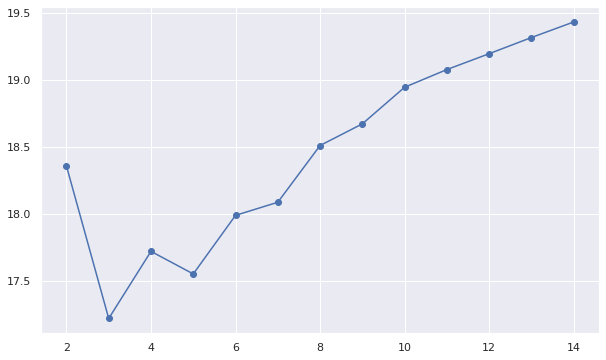

In [66]:
errors = []
for k in range(2,15):
    nutri_classifier = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - nutri_classifier.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

L'erreur minimal se produit en choisissant 3 voisins. Nous gardons donc ce nombre de voisin pour notre classifieur.

Regardons certaines de ces predictions :

In [67]:
y_pred = nutri_classifier.predict(X_test)

stacked = np.column_stack((y_pred, y_test))

print("Prédiction", f'{"Réelle":^10}')
for [i,j] in stacked[:80]:
    print(f'{i:^10}',f'{j:^10}')

Prédiction   Réelle  
    c          c     
    c          b     
    a          b     
    c          c     
    c          c     
    c          c     
    b          b     
    c          c     
    d          d     
    e          e     
    b          b     
    a          a     
    b          b     
    d          e     
    a          a     
    e          e     
    d          d     
    c          c     
    c          b     
    d          d     
    c          c     
    d          d     
    d          d     
    a          a     
    c          c     
    d          e     
    c          c     
    c          c     
    d          d     
    d          e     
    a          a     
    a          a     
    d          d     
    a          b     
    d          d     
    a          a     
    d          d     
    e          e     
    d          d     
    a          a     
    a          b     
    d          d     
    a          a     
    d          c     
    d     

On peut voir que, aussi en s'appuyant sur le score que ce modèle marche assez bien pour remplir le nutriscore. Nous rentraînons le modèle sur toutes les donnés non manquantes, pour ensuite faire le remplissage des valeurs manquantes.

In [68]:
# Les lignes qui nous intéressent pour faire les prédictions
#sont celles qui ont le nutriscore:
mask = (food_data['nutrition_grade_fr'].isnull() == False)

# Matrice de "features"
X = food_data[var_quant].loc[mask]
y = food_data['nutrition_grade_fr'].loc[mask]

In [69]:
nutri_classifier = neighbors.KNeighborsClassifier(n_neighbors=3)
nutri_classifier.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

In [70]:
print(f"Nous allons prédire les valeurs du nutriscore pour {food_data.loc[food_data['nutrition_grade_fr'].isnull() == True].shape[0]} individus.")

Nous allons prédire les valeurs du nutriscore pour 84599 individus.


In [71]:
# Condition de nutriscore non rempli:
mask_no_nutri = food_data['nutrition_grade_fr'].isnull() == True

# Matrice pour faire prédiction:
matrice_features = food_data.loc[mask_no_nutri][var_quant]

# Remplissage des valeurs manquantes avec cette prédiction:
food_data.loc[mask_no_nutri,'nutrition_grade_fr'] = nutri_classifier.predict(matrice_features)

Nous avons maintenant un dataset nettoyé:

In [72]:
food_data.isna().sum()

countries_tags        0
product_name          0
proteins_100g         0
salt_100g             0
ingredients_text      0
sugars_100g           0
fat_100g              0
carbohydrates_100g    0
saturated-fat_100g    0
nutrition_grade_fr    0
fiber_100g            0
cholesterol_100g      0
trans-fat_100g        0
calcium_100g          0
vitamin-c_100g        0
iron_100g             0
vitamin-a_100g        0
dtype: int64

## 6. Exporter dataset nettoyé <a class="anchor" id="export"></a>

In [73]:
food_data.to_csv(path_or_buf ='./food_data_clean.csv')